In [1]:
setwd('/home/neuro/model_based_fmri/EMC')
library(RhpcBLASctl)
omp_set_num_threads(1)
blas_set_num_threads(1)

Loading required package: coda

Loading required package: rtdists

Loading required package: magic

Loading required package: abind

Loading required package: MASS

Loading required package: MCMCpack

##
## Markov Chain Monte Carlo Package (MCMCpack)

## Copyright (C) 2003-2022 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park

##
## Support provided by the U.S. National Science Foundation

## (Grants SES-0350646 and SES-0350613)
##

Loading required package: corpcor

Loading required package: condMVNorm

Loading required package: mvtnorm

Loading required package: parallel



[1] "data"       "covariates"


$subjects
 [1] "as1t" "bd6t" "bl1t" "hsft" "hsgt" "kd6t" "kd9t" "kh6t" "kmat" "ku4t"
[11] "na1t" "rmbt" "rt2t" "rt3t" "rt5t" "scat" "ta5t" "vf1t" "zk1t"

$E
[1] "accuracy" "neutral"  "speed"   

$S
[1] "left"  "right"

$R
[1] "left"  "right"

$rt
NULL


as1t bd6t bl1t hsft hsgt kd6t kd9t kh6t kmat ku4t na1t rmbt rt2t rt3t rt5t scat 
 810  849  843  848  849  849  849  837  846  845  848  831  842  843  691  849 
ta5t vf1t zk1t 
 845  838  806 

     v    v_S      a a_Ea-n a_Ea-s     t0      Z 
     0      0      0      0      0      0      0 
attr(,"map")
attr(,"map")$v
   v v_S
1  1  -1
20 1   1

attr(,"map")$a
   a a_Ea-n a_Ea-s
1  1      0      0
39 1     -1      0
77 1      0     -1

attr(,"map")$sv
  sv
1  1

attr(,"map")$t0
  t0
1  1

attr(,"map")$st0
  st0
1   1

attr(,"map")$s
  s
1 1

attr(,"map")$Z
  Z
1 1

attr(,"map")$SZ
  SZ
1  1

attr(,"map")$DP
  DP
1  1



v    v_S      a a_Ea-n a_Ea-s     t0      Z 
     0      0      0      0      0      0      0 
attr(,"map")
attr(,"map")$v
   v v_S
1  1  -1
20 1   1

attr(,"map")$a
   a a_Ea-n a_Ea-s
1  1      0      0
39 1     -1      0
77 1      0     -1

attr(,"map")$sv
  sv
1  1

attr(,"map")$t0
  t0
1  1

attr(,"map")$st0
  st0
1   1

attr(,"map")$s
  s
1 1

attr(,"map")$Z
  Z
1 1

attr(,"map")$SZ
  SZ
1  1

attr(,"map")$DP
  DP
1  1

Processing data set 1

Likelihood speedup factor: 4

Loading required package: Matrix


Attaching package: ‘matrixcalc’


The following object is masked from ‘package:corpcor’:

    is.positive.definite


The following object is masked from ‘package:MCMCpack’:

    vech


Getting initial 400 samples (first  100  then removed)

Finished initial run

Beginning iterations to achieve Rhat < 1.2

Exit on max alpha psrf/mpsrf < 1.2


Final multivariate gelman.diag per participant

Iterations = 400, Mean mpsrf= 1.002, Max alpha mpsrf/psrf = 1.011

Running adapt stage



ERROR: Error in lapply(samplers_new, extract_samples, stage = "adapt", thin = thin, : object 'extract_samples' not found


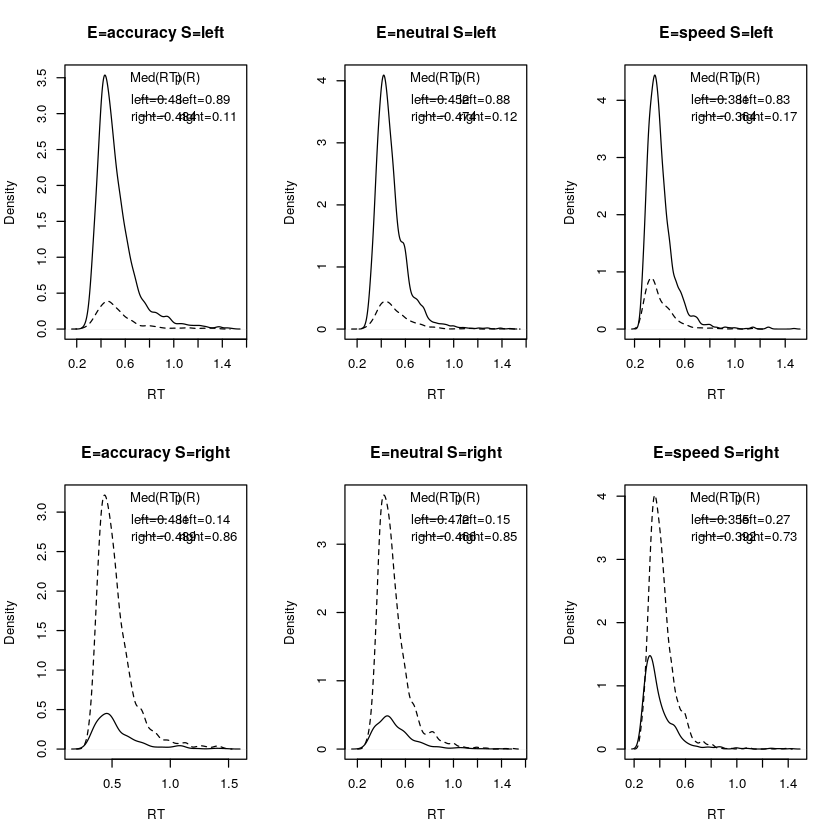

In [2]:
#### Setup ----
rm(list=ls())
source("emc/emc.R")
source("models/DDM/DDM/ddmTZD.R")
# NB: The "TZD" parameterization defined relative to the "rtdists" package is:
  # natural scale
  #   v = rtdists rate v (positive favors upper)
  # log scale 
  #   t0 > 0: lower bound of non-decision time 
  #   st0 > 0: rtdists width of non-decision time distribution 
  #   a > 0: rtdists upper threshold, a
  #   sv > 0: rtdists v standard deviation sv
  #   s > 0: rtdists moment-to-moment standard deviation, s
  # probit scale
  #   0 < Z < 1: rtdists start point z = Z*a 
  #   0 < SZ < 1: rtdists start-point variability, sz = 2*SZ*min(c(a*Z,a*(1-Z)) 
  #   0 < DP < 1: rtdists d = t0(upper)-t0(lower) = (2*DP-1)*t0


#### Format the data to be analyzed ----

print(load("Data/PNAS.RData"))
# Note that this data was censored at 0.25s and 1.5s

dat <- data[,c("s","E","S","R","RT")]
names(dat)[c(1,5)] <- c("subjects","rt")
levels(dat$R) <- levels(dat$S)

#### Explore the data ----

# 3 x 2 design, 19 subjects
lapply(dat,levels)
# $subjects
#  [1] "as1t" "bd6t" "bl1t" "hsft" "hsgt" "kd6t" "kd9t" "kh6t"
#  [9] "kmat" "ku4t" "na1t" "rmbt" "rt2t" "rt3t" "rt5t" "scat"
# [17] "ta5t" "vf1t" "zk1t"
# 
# $E
# [1] "accuracy" "neutral"  "speed"   
# 
# $S
# [1] "left"  "right"
# 
# $R
# [1] "left"  "right"
# 
# $rt
# NULL

# 800 trials per subject
table(dat$subjects)
# as1t bd6t bl1t hsft hsgt kd6t kd9t kh6t kmat ku4t na1t rmbt rt2t 
#  810  849  843  848  849  849  849  837  846  845  848  831  842 
# rt3t rt5t scat ta5t vf1t zk1t 
#  843  691  849  845  838  806
 
# 70-90% accuracy, .35s - .5s mean RT
plot_defective_density(dat,factors=c("E","S"),layout=c(2,3))


#### Set up the design ----

# Test E factor with Accuracy - Neutral &  Accuracy - Speed contrasts
Emat <- matrix(c(0,-1,0,0,0,-1),nrow=3)
dimnames(Emat) <- list(NULL,c("a-n","a-s"))

# Test stimulus factor with intercept and right-left factor. When applied to rate 
# parameter v_S is the traditional DDM "drift rate" parameter. The 
# intercept term is drift bias. If it is zero drift rate is the same for left
# and right, if positive rate bias favors right, when negative left, e.g.,
# intercept v = 1, v_S = 2 implies an upper rate of 3 and lower rate of -1. 
Vmat <- matrix(c(-1,1),ncol=1,dimnames=list(NULL,""))  

######## Wiener diffusion model ----

# Fit a Wiener diffusion model where between-trial variability parameters are set
# to zero in "constants" (NB: this is done on the sampled scale, so qnorm (probit)
# for DP and SZ and log for st0 and sv) with the traditional characterization of
# the speed vs. accuracy emphasis factor (E) selectively influencing threshold (a), 
# and stimulus (S) affecting rate (v). In order to make the model identifiable
# we set moment-to-moment variability to the conventional value of 1. 

design_a <- make_design(
  Ffactors=list(subjects=levels(dat$subjects),S=levels(dat$S),E=levels(dat$E)),
  Rlevels=levels(dat$R),
  Clist=list(S=Vmat,E=Emat),
  Flist=list(v~S,a~E,sv~1, t0~1, st0~1, s~1, Z~1, SZ~1, DP~1),
  constants=c(s=log(1),st0=log(0),DP=qnorm(0.5),SZ=qnorm(0),sv=log(0)),
  model=ddmTZD)

# This produces a 7 parameter model
sampled_p_vector(design_a)

# v is the rate intercept, and v_S the traditional drift rate, a is the threshold
# for accuracy, a_Ea-n accuracy-neutral and a_Ea-s accuracy - neutral. t0 is the
# mean non-decision time and Z the proportional start-point bias (unbiased Z=0.5).

# We will fit a "standard" hierarchical model that allows for population 
# correlations among all parameters (7 x (7-1) /2 = 21 correlations), along with 
# population mean (mu) and variance estimates for each parameter. 

# Here we use the default hyper-prior, reproduced here explicitly (the same
# is obtained if the prior argument is omitted from make_samplers). It sets a
# mean of zero and a variance of 1 for all parameters and assumes they are 
# independent. 
prior=list(theta_mu_mean = rep(0, 7), theta_mu_var = diag(rep(5, 7)))

# make_samplers combines the data and design and makes a list of n_chains
# pmwg objects ready for sampling. Here we use the default 3 chains. Each will
# be sampled independently (multiple chains are useful for assessing convergence).
samplers <- make_samplers(dat,design_a,type="single",
                          prior_list=prior,n_chains=3,rt_resolution=.02)
# make_samplers also compresses the data, grouping together trials with the same 
# parametersand rt's that differ less than the value specified in the rt_resolution 
# argument. Here we use the default which assumes a seconds scale (using 
# seconds is STRONGLY recommended) appropriate to visual stimuli presented on a
# monitor with 50Hz refresh (i.e., refreshing each 0.02s). Uniform random error
# in rt measurement is introduced in such a setup unless timing is coordinated
# with the sync pulse. Response devices such as the mouse or keyboard buttons
# introduce further error, so this setting is quite conservative. Taking 
# measurement resolution can substantially speed up likelihood calculation, the
# key bottleneck in sampling, in this case by a factor of 4

# save(samplers,file="sPNAS_a.RData")

#### Explore the fitting script ----  

#  Fitting is performed in the script sPNAS_a.R (e.g., on a linux based system
# the command line is R CMD BATCH sPNAS_a.R & to run it in background)

# We use three procedures that run the "burn", "adapt" and "sample" until they
# produce samples with the required characteristics. By default each chain gets 
# its own cores (this can be set with the cores_for_chains argument) and the 
# cores_per_chain argument above gives each chain 2 cores, so 6 are used in 
# total. Here are the functions called by sPNAS_a.R
# 
# The first "burn" stage by default runs 500 iterations, discards the first 200 
# and repeatedly trys adding new iterations (and possibly removing initial)
# iterations until R hat is less than a criterion (1.1 by default) for all
# random effect parameters in all chains. The aim of this stage is to find
# the posterior mode and get chains suitable for the next "adapt" stage.

sPNAS_a <- auto_burn(samplers,cores_per_chain=2)
#
# The "adapt" stage develops and approximation to the posterior that will make
# sampling more efficient (less autocorrelated) in the final "sample" stage.
#
sPNAS_a <- auto_adapt(sPNAS_a,cores_per_chain=2)
#
# Here in the final sample stage we ask for 1000 iterations per chain.
#
sPNAS_a <- auto_sample(sPNAS_a,iter=1000,cores_per_chain=2)
# 
# Once sampling is completed the script also gets posterior predictive samples
# to enable model fit checks. By default this is based on randomly selecting 
# iterations from the final (sample) stage, and provides posterior predictives 
# for the random effects. Here we use one core pre participant.
# ppPNAS_a <- post_predict(sPNAS_a,n_cores=19)

In [9]:
pdf('./sPNAS_a_chains.ng', width=8, height=8)
plot_chains(sPNAS_a, selection='alpha', filter='burn')
dev.off()

png 
  2

In [8]:
getwd()

[1] "/home/neuro/model_based_fmri/EMC"